In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)


# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [8, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-11 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = False
AUGMENT_PHASES_RANGE = (-3,3)
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10

# Data paths
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'



Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-24 09:09:05,287 INFO -------------------- Start --------------------
2021-02-24 09:09:05,287 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-24 09:09:05,287 INFO Log file: ./logs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug.log
2021-02-24 09:09:05,288 INFO Log level for console: INFO
2021-02-24 09:09:05,289 INFO Is built with tensorflow: True
2021-02-24 09:09:05,362 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug', 'MODEL_PATH': 'models/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_09_09', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_09_09', 'CONFIG_PATH': 'reports/configs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_09_09', 'HISTORY_PATH': 'reports/history/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_09_09', 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'SPACING': [8, 3, 3], 'DEPTH': 3, 'FILTERS': 32, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'OPTIMIZER': 'adam', 'AC

2021-02-24 09:09:06,019 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5931528032384992060
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8967198959275462896
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14426018074026252255
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 104414668548982593
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23152016768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11277332709364074697
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23561682304
locality {
  bus_id

In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
# add randomness, but idempotent, this issimilar to shuffle but we could leave some data out
images = random.sample(images, len(images))
print(len(images))

278


In [3]:
images[83]

'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/0000-K61NJJ2D_2007-05-29_volume_clean.nrrd'

In [4]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [14]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(images[:220], images[:220], config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(images[220:], images[220:] , config=val_config)

2021-02-24 09:19:17,545 INFO Create DataGenerator
2021-02-24 09:19:17,546 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 220 
 Augment: True 
 Thread workers: 8
2021-02-24 09:19:17,547 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-02-24 09:19:17,559 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-24 09:19:17,559 INFO Temporal phase augmentation: False
2021-02-24 09:19:17,560 INFO Create DataGenerator
2021-02-24 09:19:17,560 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 58 
 Augment: False 
 Thread workers: 8
2021-02-24 09:19:17,561 INFO No augmentation
2021-02-24 09:19:17,573 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-24 09:19:17,573 INFO Temporal phase augmentation: False


In [15]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(validation_generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = validation_generator.__getitem__(batch)
    outputs, gt_len = outputs
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im]
        selected_gtlen = int(gt_len[im])
        logging.info('GT length: {}'.format(selected_gtlen))

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=3, description='batch', max=7), IntSlider(value=3, description='im', max…

In [8]:
# test if all batches are processable
"""for b in range(len(validation_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [11]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
encoder
(None, 36, 256)
bi LSTM
(None, 36, 64)
conv1d 32 3,1
(None, 36, 64)
(None, 36, 5)


In [12]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_2 (TensorFlowOpLayer)        [(None, 36, 64, 64, 1), (None, 3 0                 input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_3 (ConvEncoder)                     ((None, 36, 8, 

In [13]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    #steps_per_epoch=len(batch_generator),
    validation_data=validation_generator,
    #validation_steps=len(validation_generator),
    epochs=200,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    #workers=2,
    use_multiprocessing=False,
    verbose=1)

2021-02-23 22:19:44,879 INFO feed 4 Tensorboard is ready


Epoch 1/200
27/27 [==============================] - ETA: 0s - loss: 1.7354 - categorical_accuracy: 0.3286 - mean_squared_error: 0.0991 - mean_absolute_error: 0.2393 - meandiff: 14.7926

2021-02-23 22:21:03,624 INFO (4, 36, 5)
2021-02-23 22:21:04,161 INFO (4, 36, 5)


27/27 [==============================] - 48s 2s/step - loss: 1.7354 - categorical_accuracy: 0.3286 - mean_squared_error: 0.0991 - mean_absolute_error: 0.2393 - meandiff: 14.7926 - val_loss: 1.6386 - val_categorical_accuracy: 0.2202 - val_mean_squared_error: 0.1019 - val_mean_absolute_error: 0.2525 - val_meandiff: 19.8857 - lr: 1.0000e-04
Epoch 2/200
27/27 [==============================] - ETA: 0s - loss: 1.4452 - categorical_accuracy: 0.5008 - mean_squared_error: 0.0745 - mean_absolute_error: 0.2021 - meandiff: 10.5333

2021-02-23 22:21:49,861 INFO (4, 36, 5)
2021-02-23 22:21:50,393 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.4452 - categorical_accuracy: 0.5008 - mean_squared_error: 0.0745 - mean_absolute_error: 0.2021 - meandiff: 10.5333 - val_loss: 1.5771 - val_categorical_accuracy: 0.2312 - val_mean_squared_error: 0.0961 - val_mean_absolute_error: 0.2449 - val_meandiff: 9.1143 - lr: 1.0000e-04
Epoch 3/200
27/27 [==============================] - ETA: 0s - loss: 1.3463 - categorical_accuracy: 0.5896 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1754 - meandiff: 8.4630

2021-02-23 22:22:37,457 INFO (4, 36, 5)
2021-02-23 22:22:37,963 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.3463 - categorical_accuracy: 0.5896 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1754 - meandiff: 8.4630 - val_loss: 1.4472 - val_categorical_accuracy: 0.5035 - val_mean_squared_error: 0.0810 - val_mean_absolute_error: 0.2226 - val_meandiff: 8.2857 - lr: 1.0000e-04
Epoch 4/200
27/27 [==============================] - ETA: 0s - loss: 1.2967 - categorical_accuracy: 0.6310 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1645 - meandiff: 8.4407

2021-02-23 22:23:23,915 INFO (4, 36, 5)
2021-02-23 22:23:24,425 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.2967 - categorical_accuracy: 0.6310 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1645 - meandiff: 8.4407 - val_loss: 1.4301 - val_categorical_accuracy: 0.5005 - val_mean_squared_error: 0.0764 - val_mean_absolute_error: 0.2098 - val_meandiff: 7.1857 - lr: 1.0000e-04
Epoch 5/200
27/27 [==============================] - 45s 2s/step - loss: 1.2839 - categorical_accuracy: 0.6512 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1607 - meandiff: 8.5222 - val_loss: 1.3195 - val_categorical_accuracy: 0.6389 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1901 - val_meandiff: 8.5714 - lr: 1.0000e-04
Epoch 6/200
27/27 [==============================] - ETA: 0s - loss: 1.2337 - categorical_accuracy: 0.6912 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1471 - meandiff: 8.4074

2021-02-23 22:24:57,254 INFO (4, 36, 5)
2021-02-23 22:24:57,761 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.2337 - categorical_accuracy: 0.6912 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1471 - meandiff: 8.4074 - val_loss: 1.2295 - val_categorical_accuracy: 0.6865 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1601 - val_meandiff: 8.2286 - lr: 1.0000e-04
Epoch 7/200
27/27 [==============================] - 42s 2s/step - loss: 1.2085 - categorical_accuracy: 0.7149 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1410 - meandiff: 8.2778 - val_loss: 1.1926 - val_categorical_accuracy: 0.7217 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1425 - val_meandiff: 9.4714 - lr: 1.0000e-04
Epoch 8/200
27/27 [==============================] - ETA: 0s - loss: 1.2001 - categorical_accuracy: 0.7229 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1367 - meandiff: 7.9481

2021-02-23 22:26:28,419 INFO (4, 36, 5)
2021-02-23 22:26:28,944 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.2001 - categorical_accuracy: 0.7229 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1367 - meandiff: 7.9481 - val_loss: 1.2225 - val_categorical_accuracy: 0.7277 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1367 - val_meandiff: 8.6429 - lr: 1.0000e-04
Epoch 9/200
27/27 [==============================] - 43s 2s/step - loss: 1.2033 - categorical_accuracy: 0.7167 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1374 - meandiff: 7.9222 - val_loss: 1.1993 - val_categorical_accuracy: 0.7490 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1225 - val_meandiff: 7.4000 - lr: 1.0000e-04
Epoch 10/200
27/27 [==============================] - ETA: 0s - loss: 1.1768 - categorical_accuracy: 0.7442 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1310 - meandiff: 8.0259

2021-02-23 22:28:00,092 INFO (4, 36, 5)
2021-02-23 22:28:00,990 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.1768 - categorical_accuracy: 0.7442 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1310 - meandiff: 8.0259 - val_loss: 1.1960 - val_categorical_accuracy: 0.7708 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1193 - val_meandiff: 7.1714 - lr: 1.0000e-04
Epoch 11/200
27/27 [==============================] - 41s 2s/step - loss: 1.1634 - categorical_accuracy: 0.7577 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1268 - meandiff: 8.0815 - val_loss: 1.2033 - val_categorical_accuracy: 0.7703 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1105 - val_meandiff: 7.9429 - lr: 1.0000e-04
Epoch 12/200
27/27 [==============================] - ETA: 0s - loss: 1.1513 - categorical_accuracy: 0.7758 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1237 - meandiff: 8.0815

2021-02-23 22:29:31,515 INFO (4, 36, 5)
2021-02-23 22:29:32,050 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.1513 - categorical_accuracy: 0.7758 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1237 - meandiff: 8.0815 - val_loss: 1.2815 - val_categorical_accuracy: 0.7336 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1204 - val_meandiff: 9.6143 - lr: 1.0000e-04
Epoch 13/200
27/27 [==============================] - 43s 2s/step - loss: 1.1527 - categorical_accuracy: 0.7623 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1233 - meandiff: 8.0333 - val_loss: 1.4061 - val_categorical_accuracy: 0.6711 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1358 - val_meandiff: 8.1429 - lr: 1.0000e-04
Epoch 14/200
27/27 [==============================] - ETA: 0s - loss: 1.1613 - categorical_accuracy: 0.7560 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1246 - meandiff: 7.7889

2021-02-23 22:31:04,663 INFO (4, 36, 5)
2021-02-23 22:31:05,180 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.1613 - categorical_accuracy: 0.7560 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1246 - meandiff: 7.7889 - val_loss: 1.3895 - val_categorical_accuracy: 0.6830 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1390 - val_meandiff: 7.5714 - lr: 1.0000e-04
Epoch 15/200
27/27 [==============================] - 44s 2s/step - loss: 1.1451 - categorical_accuracy: 0.7762 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1209 - meandiff: 7.3778 - val_loss: 1.3137 - val_categorical_accuracy: 0.7207 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1209 - val_meandiff: 6.6143 - lr: 1.0000e-04
Epoch 16/200
27/27 [==============================] - ETA: 0s - loss: 1.1400 - categorical_accuracy: 0.7762 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1190 - meandiff: 8.0852

2021-02-23 22:32:37,072 INFO (4, 36, 5)
2021-02-23 22:32:37,583 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.1400 - categorical_accuracy: 0.7762 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1190 - meandiff: 8.0852 - val_loss: 1.2859 - val_categorical_accuracy: 0.7664 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1107 - val_meandiff: 8.0429 - lr: 1.0000e-04
Epoch 17/200
27/27 [==============================] - 45s 2s/step - loss: 1.1350 - categorical_accuracy: 0.7888 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1171 - meandiff: 8.0963 - val_loss: 1.2277 - val_categorical_accuracy: 0.7778 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1026 - val_meandiff: 7.3286 - lr: 1.0000e-04
Epoch 18/200
27/27 [==============================] - ETA: 0s - loss: 1.1274 - categorical_accuracy: 0.7953 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1151 - meandiff: 8.0074

2021-02-23 22:34:10,060 INFO (4, 36, 5)
2021-02-23 22:34:10,576 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.1274 - categorical_accuracy: 0.7953 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1151 - meandiff: 8.0074 - val_loss: 1.2680 - val_categorical_accuracy: 0.7594 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1102 - val_meandiff: 6.5714 - lr: 1.0000e-04
Epoch 19/200
27/27 [==============================] - 43s 2s/step - loss: 1.1287 - categorical_accuracy: 0.7879 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1157 - meandiff: 8.3222 - val_loss: 1.2825 - val_categorical_accuracy: 0.7560 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1085 - val_meandiff: 6.2571 - lr: 1.0000e-04
Epoch 20/200
27/27 [==============================] - ETA: 0s - loss: 1.1226 - categorical_accuracy: 0.7986 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1132 - meandiff: 8.4037

2021-02-23 22:35:40,539 INFO (4, 36, 5)
2021-02-23 22:35:41,057 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.1226 - categorical_accuracy: 0.7986 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1132 - meandiff: 8.4037 - val_loss: 1.2400 - val_categorical_accuracy: 0.7619 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1043 - val_meandiff: 5.3429 - lr: 1.0000e-04
Epoch 21/200
27/27 [==============================] - 43s 2s/step - loss: 1.1205 - categorical_accuracy: 0.7993 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1124 - meandiff: 7.8852 - val_loss: 1.1848 - val_categorical_accuracy: 0.8140 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.0942 - val_meandiff: 7.8143 - lr: 1.0000e-04
Epoch 22/200
27/27 [==============================] - ETA: 0s - loss: 1.1187 - categorical_accuracy: 0.7999 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1110 - meandiff: 7.9852

2021-02-23 22:37:12,593 INFO (4, 36, 5)
2021-02-23 22:37:13,106 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.1187 - categorical_accuracy: 0.7999 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1110 - meandiff: 7.9852 - val_loss: 1.1640 - val_categorical_accuracy: 0.7971 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.0971 - val_meandiff: 6.3000 - lr: 1.0000e-04
Epoch 23/200
27/27 [==============================] - 44s 2s/step - loss: 1.1184 - categorical_accuracy: 0.8020 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1117 - meandiff: 8.3778 - val_loss: 1.1611 - val_categorical_accuracy: 0.8120 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.0930 - val_meandiff: 7.5143 - lr: 1.0000e-04
Epoch 24/200
27/27 [==============================] - ETA: 0s - loss: 1.1134 - categorical_accuracy: 0.8053 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1097 - meandiff: 8.4519

2021-02-23 22:38:46,379 INFO (4, 36, 5)
2021-02-23 22:38:46,893 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.1134 - categorical_accuracy: 0.8053 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1097 - meandiff: 8.4519 - val_loss: 1.1588 - val_categorical_accuracy: 0.8021 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.0961 - val_meandiff: 6.3000 - lr: 1.0000e-04
Epoch 25/200
27/27 [==============================] - 42s 2s/step - loss: 1.1109 - categorical_accuracy: 0.8121 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1097 - meandiff: 8.1111 - val_loss: 1.1731 - val_categorical_accuracy: 0.8075 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.0900 - val_meandiff: 6.8714 - lr: 1.0000e-04
Epoch 26/200
27/27 [==============================] - ETA: 0s - loss: 1.1133 - categorical_accuracy: 0.8053 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1092 - meandiff: 7.6000

2021-02-23 22:40:17,530 INFO (4, 36, 5)
2021-02-23 22:40:18,487 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.1133 - categorical_accuracy: 0.8053 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1092 - meandiff: 7.6000 - val_loss: 1.2171 - val_categorical_accuracy: 0.7525 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1079 - val_meandiff: 5.5143 - lr: 1.0000e-04
Epoch 27/200
27/27 [==============================] - 42s 2s/step - loss: 1.1206 - categorical_accuracy: 0.7999 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1127 - meandiff: 8.5741 - val_loss: 1.1701 - val_categorical_accuracy: 0.7961 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.0989 - val_meandiff: 7.6000 - lr: 1.0000e-04
Epoch 28/200
27/27 [==============================] - ETA: 0s - loss: 1.1079 - categorical_accuracy: 0.8134 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1085 - meandiff: 7.5926

2021-02-23 22:41:49,201 INFO (4, 36, 5)
2021-02-23 22:41:49,746 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.1079 - categorical_accuracy: 0.8134 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1085 - meandiff: 7.5926 - val_loss: 1.1897 - val_categorical_accuracy: 0.7976 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.0913 - val_meandiff: 7.4429 - lr: 1.0000e-04
Epoch 29/200
27/27 [==============================] - 41s 2s/step - loss: 1.1029 - categorical_accuracy: 0.8121 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1058 - meandiff: 8.3148 - val_loss: 1.1697 - val_categorical_accuracy: 0.7827 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1030 - val_meandiff: 6.4714 - lr: 1.0000e-04
Epoch 30/200
27/27 [==============================] - ETA: 0s - loss: 1.1086 - categorical_accuracy: 0.8135 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1081 - meandiff: 7.9074

2021-02-23 22:43:17,425 INFO (4, 36, 5)
2021-02-23 22:43:17,948 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.1086 - categorical_accuracy: 0.8135 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1081 - meandiff: 7.9074 - val_loss: 1.1240 - val_categorical_accuracy: 0.8145 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0930 - val_meandiff: 6.1143 - lr: 1.0000e-04
Epoch 31/200
27/27 [==============================] - 43s 2s/step - loss: 1.1018 - categorical_accuracy: 0.8189 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1064 - meandiff: 7.9370 - val_loss: 1.1622 - val_categorical_accuracy: 0.7877 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.0985 - val_meandiff: 5.9000 - lr: 1.0000e-04
Epoch 32/200
27/27 [==============================] - ETA: 0s - loss: 1.1022 - categorical_accuracy: 0.8165 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1066 - meandiff: 8.2148

2021-02-23 22:44:47,774 INFO (4, 36, 5)
2021-02-23 22:44:48,748 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.1022 - categorical_accuracy: 0.8165 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1066 - meandiff: 8.2148 - val_loss: 1.1242 - val_categorical_accuracy: 0.8294 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.0877 - val_meandiff: 7.2143 - lr: 1.0000e-04
Epoch 33/200
27/27 [==============================] - 42s 2s/step - loss: 1.1044 - categorical_accuracy: 0.8138 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1067 - meandiff: 8.0593 - val_loss: 1.1681 - val_categorical_accuracy: 0.7862 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.0984 - val_meandiff: 7.5000 - lr: 1.0000e-04
Epoch 34/200
27/27 [==============================] - ETA: 0s - loss: 1.0958 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1045 - meandiff: 8.1370

2021-02-23 22:46:19,243 INFO (4, 36, 5)
2021-02-23 22:46:19,753 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0958 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1045 - meandiff: 8.1370 - val_loss: 1.1204 - val_categorical_accuracy: 0.8155 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.0915 - val_meandiff: 6.8714 - lr: 1.0000e-04
Epoch 35/200
27/27 [==============================] - 43s 2s/step - loss: 1.1049 - categorical_accuracy: 0.8149 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1061 - meandiff: 8.3481 - val_loss: 1.1485 - val_categorical_accuracy: 0.7887 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1013 - val_meandiff: 6.8000 - lr: 1.0000e-04
Epoch 36/200
27/27 [==============================] - ETA: 0s - loss: 1.0967 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1044 - meandiff: 7.9407

2021-02-23 22:47:51,520 INFO (4, 36, 5)
2021-02-23 22:47:52,026 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0967 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1044 - meandiff: 7.9407 - val_loss: 1.1528 - val_categorical_accuracy: 0.7748 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1065 - val_meandiff: 6.2286 - lr: 1.0000e-04
Epoch 37/200
27/27 [==============================] - 41s 2s/step - loss: 1.0922 - categorical_accuracy: 0.8251 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1018 - meandiff: 7.7778 - val_loss: 1.1149 - val_categorical_accuracy: 0.8209 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.0901 - val_meandiff: 6.3286 - lr: 1.0000e-04
Epoch 38/200
27/27 [==============================] - ETA: 0s - loss: 1.0913 - categorical_accuracy: 0.8291 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1024 - meandiff: 8.1556

2021-02-23 22:49:21,369 INFO (4, 36, 5)
2021-02-23 22:49:21,882 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.0913 - categorical_accuracy: 0.8291 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1024 - meandiff: 8.1556 - val_loss: 1.1044 - val_categorical_accuracy: 0.8219 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.0901 - val_meandiff: 7.0714 - lr: 1.0000e-04
Epoch 39/200
27/27 [==============================] - 43s 2s/step - loss: 1.0879 - categorical_accuracy: 0.8309 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1013 - meandiff: 7.7778 - val_loss: 1.1122 - val_categorical_accuracy: 0.8254 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0899 - val_meandiff: 6.2857 - lr: 1.0000e-04
Epoch 40/200
27/27 [==============================] - ETA: 0s - loss: 1.0901 - categorical_accuracy: 0.8252 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1012 - meandiff: 7.4037

2021-02-23 22:50:54,977 INFO (4, 36, 5)
2021-02-23 22:50:55,496 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0901 - categorical_accuracy: 0.8252 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1012 - meandiff: 7.4037 - val_loss: 1.1361 - val_categorical_accuracy: 0.7991 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1021 - val_meandiff: 6.5857 - lr: 1.0000e-04
Epoch 41/200
27/27 [==============================] - 43s 2s/step - loss: 1.0923 - categorical_accuracy: 0.8202 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1026 - meandiff: 7.7333 - val_loss: 1.1906 - val_categorical_accuracy: 0.7321 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1185 - val_meandiff: 7.1857 - lr: 1.0000e-04
Epoch 42/200
27/27 [==============================] - ETA: 0s - loss: 1.0921 - categorical_accuracy: 0.8230 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1025 - meandiff: 7.6926

2021-02-23 22:52:27,825 INFO (4, 36, 5)
2021-02-23 22:52:28,338 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0921 - categorical_accuracy: 0.8230 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1025 - meandiff: 7.6926 - val_loss: 1.1168 - val_categorical_accuracy: 0.8170 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0944 - val_meandiff: 8.1714 - lr: 1.0000e-04
Epoch 43/200
27/27 [==============================] - 43s 2s/step - loss: 1.0943 - categorical_accuracy: 0.8207 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1037 - meandiff: 8.1259 - val_loss: 1.1028 - val_categorical_accuracy: 0.8219 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.0902 - val_meandiff: 7.2000 - lr: 1.0000e-04
Epoch 44/200
27/27 [==============================] - ETA: 0s - loss: 1.0907 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1021 - meandiff: 7.7037

2021-02-23 22:53:59,555 INFO (4, 36, 5)
2021-02-23 22:54:00,071 INFO (4, 36, 5)



Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
27/27 [==============================] - 45s 2s/step - loss: 1.0907 - categorical_accuracy: 0.8209 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1021 - meandiff: 7.7037 - val_loss: 1.1252 - val_categorical_accuracy: 0.8046 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1013 - val_meandiff: 9.8143 - lr: 3.0000e-05
Epoch 45/200
27/27 [==============================] - 43s 2s/step - loss: 1.0823 - categorical_accuracy: 0.8304 - mean_squared_error: 0.0220 - mean_absolute_error: 0.0986 - meandiff: 7.8259 - val_loss: 1.1220 - val_categorical_accuracy: 0.8090 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.0985 - val_meandiff: 8.0571 - lr: 3.0000e-05
Epoch 46/200
27/27 [==============================] - ETA: 0s - loss: 1.0822 - categorical_accuracy: 0.8342 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0993 - meandiff: 7.5630

2021-02-23 22:55:31,099 INFO (4, 36, 5)
2021-02-23 22:55:31,607 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0822 - categorical_accuracy: 0.8342 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0993 - meandiff: 7.5630 - val_loss: 1.1138 - val_categorical_accuracy: 0.8175 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.0978 - val_meandiff: 6.1857 - lr: 3.0000e-05
Epoch 47/200
27/27 [==============================] - 42s 2s/step - loss: 1.0826 - categorical_accuracy: 0.8338 - mean_squared_error: 0.0221 - mean_absolute_error: 0.0986 - meandiff: 7.5630 - val_loss: 1.1195 - val_categorical_accuracy: 0.8130 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.0980 - val_meandiff: 7.8286 - lr: 3.0000e-05
Epoch 48/200
27/27 [==============================] - ETA: 0s - loss: 1.0825 - categorical_accuracy: 0.8333 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0992 - meandiff: 7.8259

2021-02-23 22:57:01,741 INFO (4, 36, 5)
2021-02-23 22:57:02,253 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0825 - categorical_accuracy: 0.8333 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0992 - meandiff: 7.8259 - val_loss: 1.1388 - val_categorical_accuracy: 0.7971 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1030 - val_meandiff: 7.6571 - lr: 3.0000e-05
Epoch 49/200
27/27 [==============================] - 42s 2s/step - loss: 1.0824 - categorical_accuracy: 0.8382 - mean_squared_error: 0.0220 - mean_absolute_error: 0.0983 - meandiff: 8.0778 - val_loss: 1.1058 - val_categorical_accuracy: 0.8229 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.0924 - val_meandiff: 8.1571 - lr: 3.0000e-05
Epoch 50/200
27/27 [==============================] - ETA: 0s - loss: 1.0831 - categorical_accuracy: 0.8341 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0997 - meandiff: 8.1926

2021-02-23 22:58:31,236 INFO (4, 36, 5)
2021-02-23 22:58:31,747 INFO (4, 36, 5)



Epoch 00050: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
27/27 [==============================] - 43s 2s/step - loss: 1.0831 - categorical_accuracy: 0.8341 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0997 - meandiff: 8.1926 - val_loss: 1.1297 - val_categorical_accuracy: 0.8031 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1026 - val_meandiff: 6.7857 - lr: 9.0000e-06
Epoch 51/200
27/27 [==============================] - 43s 2s/step - loss: 1.0808 - categorical_accuracy: 0.8385 - mean_squared_error: 0.0219 - mean_absolute_error: 0.0989 - meandiff: 7.3148 - val_loss: 1.1124 - val_categorical_accuracy: 0.8170 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.0989 - val_meandiff: 7.3571 - lr: 9.0000e-06
Epoch 52/200
27/27 [==============================] - ETA: 0s - loss: 1.0787 - categorical_accuracy: 0.8386 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0982 - meandiff: 7.9037

2021-02-23 23:00:02,456 INFO (4, 36, 5)
2021-02-23 23:00:02,985 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0787 - categorical_accuracy: 0.8386 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0982 - meandiff: 7.9037 - val_loss: 1.1333 - val_categorical_accuracy: 0.7961 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1052 - val_meandiff: 8.2857 - lr: 9.0000e-06
Epoch 53/200
27/27 [==============================] - 43s 2s/step - loss: 1.0814 - categorical_accuracy: 0.8329 - mean_squared_error: 0.0218 - mean_absolute_error: 0.0980 - meandiff: 7.9593 - val_loss: 1.1261 - val_categorical_accuracy: 0.8031 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1010 - val_meandiff: 8.5286 - lr: 9.0000e-06
Epoch 54/200
27/27 [==============================] - ETA: 0s - loss: 1.0803 - categorical_accuracy: 0.8382 - mean_squared_error: 0.0219 - mean_absolute_error: 0.0982 - meandiff: 7.3704

2021-02-23 23:01:33,988 INFO (4, 36, 5)
2021-02-23 23:01:34,506 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0803 - categorical_accuracy: 0.8382 - mean_squared_error: 0.0219 - mean_absolute_error: 0.0982 - meandiff: 7.3704 - val_loss: 1.1296 - val_categorical_accuracy: 0.8041 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1021 - val_meandiff: 8.3000 - lr: 9.0000e-06
Epoch 55/200
27/27 [==============================] - 43s 2s/step - loss: 1.0817 - categorical_accuracy: 0.8346 - mean_squared_error: 0.0221 - mean_absolute_error: 0.0988 - meandiff: 8.5444 - val_loss: 1.1240 - val_categorical_accuracy: 0.8065 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1010 - val_meandiff: 7.8714 - lr: 9.0000e-06
Epoch 56/200
27/27 [==============================] - ETA: 0s - loss: 1.0772 - categorical_accuracy: 0.8394 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0973 - meandiff: 7.0704

2021-02-23 23:03:05,887 INFO (4, 36, 5)
2021-02-23 23:03:06,400 INFO (4, 36, 5)


27/27 [==============================] - 44s 2s/step - loss: 1.0772 - categorical_accuracy: 0.8394 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0973 - meandiff: 7.0704 - val_loss: 1.1299 - val_categorical_accuracy: 0.8026 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1024 - val_meandiff: 7.6000 - lr: 9.0000e-06
Epoch 57/200
27/27 [==============================] - 42s 2s/step - loss: 1.0783 - categorical_accuracy: 0.8401 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0980 - meandiff: 7.9667 - val_loss: 1.1270 - val_categorical_accuracy: 0.8051 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1016 - val_meandiff: 7.8286 - lr: 9.0000e-06
Epoch 58/200
27/27 [==============================] - ETA: 0s - loss: 1.0778 - categorical_accuracy: 0.8412 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0971 - meandiff: 8.3259

2021-02-23 23:04:34,896 INFO (4, 36, 5)
2021-02-23 23:04:35,406 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.0778 - categorical_accuracy: 0.8412 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0971 - meandiff: 8.3259 - val_loss: 1.1324 - val_categorical_accuracy: 0.7971 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1031 - val_meandiff: 7.3857 - lr: 9.0000e-06
Epoch 59/200
27/27 [==============================] - 44s 2s/step - loss: 1.0783 - categorical_accuracy: 0.8398 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0976 - meandiff: 7.8185 - val_loss: 1.1303 - val_categorical_accuracy: 0.7961 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1033 - val_meandiff: 7.2143 - lr: 9.0000e-06
Epoch 60/200
27/27 [==============================] - ETA: 0s - loss: 1.0804 - categorical_accuracy: 0.8362 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0976 - meandiff: 8.4444

2021-02-23 23:06:06,738 INFO (4, 36, 5)
2021-02-23 23:06:07,260 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.0804 - categorical_accuracy: 0.8362 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0976 - meandiff: 8.4444 - val_loss: 1.1337 - val_categorical_accuracy: 0.7956 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1038 - val_meandiff: 8.0714 - lr: 9.0000e-06
Epoch 61/200
27/27 [==============================] - ETA: 0s - loss: 1.0798 - categorical_accuracy: 0.8322 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0976 - meandiff: 7.5704
Epoch 00061: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
27/27 [==============================] - 42s 2s/step - loss: 1.0798 - categorical_accuracy: 0.8322 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0976 - meandiff: 7.5704 - val_loss: 1.1306 - val_categorical_accuracy: 0.8041 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1024 - val_meandiff: 7.1571 - lr: 2.7000e-06
Epoch 62/200
27/27 [==============================] - ETA

2021-02-23 23:07:38,018 INFO (4, 36, 5)
2021-02-23 23:07:38,523 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0772 - categorical_accuracy: 0.8392 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0975 - meandiff: 6.7407 - val_loss: 1.1371 - val_categorical_accuracy: 0.7907 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1049 - val_meandiff: 7.6000 - lr: 2.7000e-06
Epoch 63/200
27/27 [==============================] - 42s 2s/step - loss: 1.0750 - categorical_accuracy: 0.8419 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0962 - meandiff: 7.5185 - val_loss: 1.1335 - val_categorical_accuracy: 0.7937 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1040 - val_meandiff: 7.9000 - lr: 2.7000e-06
Epoch 64/200
27/27 [==============================] - ETA: 0s - loss: 1.0786 - categorical_accuracy: 0.8412 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0974 - meandiff: 7.4222

2021-02-23 23:09:09,301 INFO (4, 36, 5)
2021-02-23 23:09:09,815 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0786 - categorical_accuracy: 0.8412 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0974 - meandiff: 7.4222 - val_loss: 1.1348 - val_categorical_accuracy: 0.7917 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1052 - val_meandiff: 7.5429 - lr: 2.7000e-06
Epoch 65/200
27/27 [==============================] - 43s 2s/step - loss: 1.0779 - categorical_accuracy: 0.8377 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0975 - meandiff: 7.9963 - val_loss: 1.1324 - val_categorical_accuracy: 0.7941 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1034 - val_meandiff: 7.0714 - lr: 2.7000e-06
Epoch 66/200
27/27 [==============================] - ETA: 0s - loss: 1.0798 - categorical_accuracy: 0.8378 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0975 - meandiff: 7.7000

2021-02-23 23:10:39,371 INFO (4, 36, 5)
2021-02-23 23:10:39,878 INFO (4, 36, 5)


27/27 [==============================] - 43s 2s/step - loss: 1.0798 - categorical_accuracy: 0.8378 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0975 - meandiff: 7.7000 - val_loss: 1.1364 - val_categorical_accuracy: 0.7912 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1054 - val_meandiff: 7.0571 - lr: 2.7000e-06
Epoch 67/200
27/27 [==============================] - 43s 2s/step - loss: 1.0807 - categorical_accuracy: 0.8373 - mean_squared_error: 0.0219 - mean_absolute_error: 0.0986 - meandiff: 7.7185 - val_loss: 1.1398 - val_categorical_accuracy: 0.7877 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1066 - val_meandiff: 7.3429 - lr: 2.7000e-06
Epoch 68/200
27/27 [==============================] - ETA: 0s - loss: 1.0775 - categorical_accuracy: 0.8401 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0977 - meandiff: 8.1556

2021-02-23 23:12:11,668 INFO (4, 36, 5)
2021-02-23 23:12:12,183 INFO (4, 36, 5)



Epoch 00068: ReduceLROnPlateau reducing learning rate to 8.099999604382901e-07.
27/27 [==============================] - 44s 2s/step - loss: 1.0775 - categorical_accuracy: 0.8401 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0977 - meandiff: 8.1556 - val_loss: 1.1370 - val_categorical_accuracy: 0.7907 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1060 - val_meandiff: 7.5429 - lr: 8.1000e-07
Epoch 69/200
27/27 [==============================] - 42s 2s/step - loss: 1.0763 - categorical_accuracy: 0.8350 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0970 - meandiff: 7.9296 - val_loss: 1.1375 - val_categorical_accuracy: 0.7927 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1057 - val_meandiff: 6.9714 - lr: 8.1000e-07
Epoch 70/200
27/27 [==============================] - ETA: 0s - loss: 1.0774 - categorical_accuracy: 0.8390 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0975 - meandiff: 7.4148

2021-02-23 23:13:43,759 INFO (4, 36, 5)
2021-02-23 23:13:44,268 INFO (4, 36, 5)


27/27 [==============================] - 46s 2s/step - loss: 1.0774 - categorical_accuracy: 0.8390 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0975 - meandiff: 7.4148 - val_loss: 1.1395 - val_categorical_accuracy: 0.7897 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1061 - val_meandiff: 7.5714 - lr: 8.1000e-07
Epoch 71/200
27/27 [==============================] - 42s 2s/step - loss: 1.0789 - categorical_accuracy: 0.8350 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0971 - meandiff: 7.8741 - val_loss: 1.1425 - val_categorical_accuracy: 0.7882 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1076 - val_meandiff: 7.1857 - lr: 8.1000e-07
Epoch 72/200
27/27 [==============================] - ETA: 0s - loss: 1.0766 - categorical_accuracy: 0.8426 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0976 - meandiff: 7.6296

2021-02-23 23:15:16,029 INFO (4, 36, 5)
2021-02-23 23:15:16,540 INFO (4, 36, 5)


27/27 [==============================] - 45s 2s/step - loss: 1.0766 - categorical_accuracy: 0.8426 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0976 - meandiff: 7.6296 - val_loss: 1.1404 - val_categorical_accuracy: 0.7892 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1070 - val_meandiff: 7.2429 - lr: 8.1000e-07
Epoch 73/200
27/27 [==============================] - 44s 2s/step - loss: 1.0759 - categorical_accuracy: 0.8416 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0964 - meandiff: 7.8778 - val_loss: 1.1389 - val_categorical_accuracy: 0.7887 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1064 - val_meandiff: 7.9000 - lr: 8.1000e-07
Epoch 00073: early stopping


In [14]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


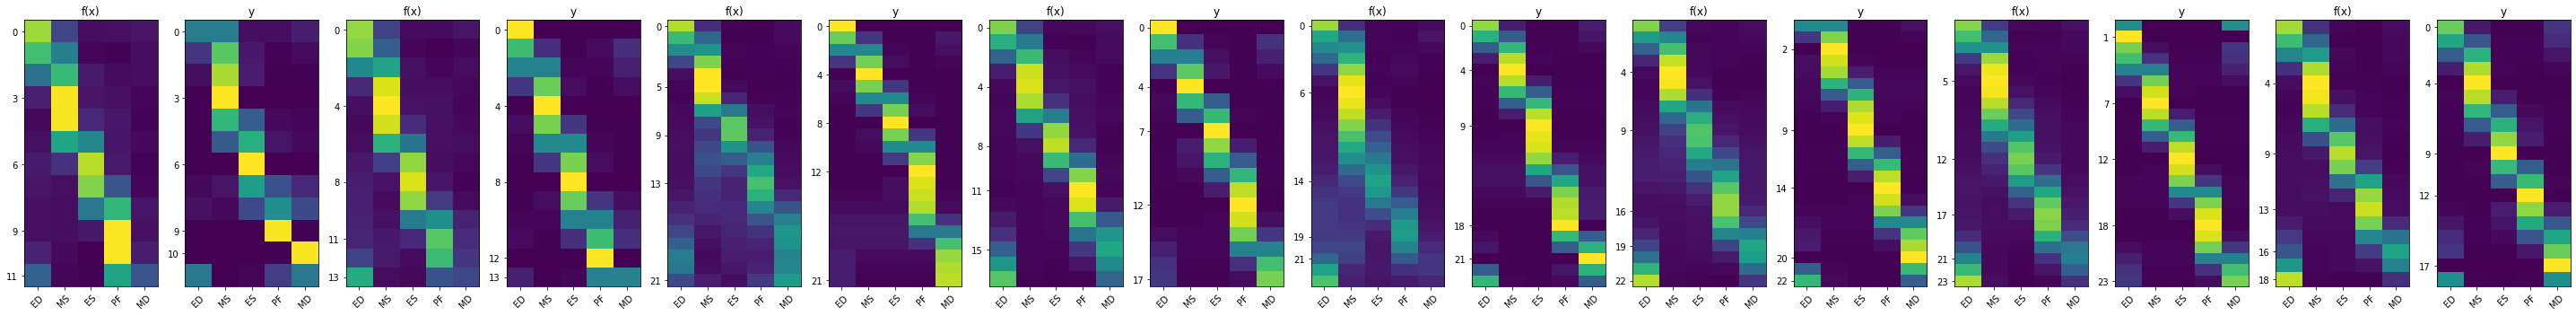

In [39]:
from src.visualization.Visualize import show_phases
_ = show_phases(outputs,pred)

In [42]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred, batchsize=BATCHSIZE).numpy()

tf.Tensor([12 14 22 18 24 23 24 19], shape=(8,), dtype=int32)
(5, 2)
tf.Tensor([ 0  3  6  9 10], shape=(5,), dtype=int64)
tf.Tensor([ 0  3  6  9 11], shape=(5,), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


KeyboardInterrupt: 

In [26]:
# calculate the meandiff score for all batches
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p, batchsize=BATCHSIZE))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=13.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=27.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.4>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=17.8>]

In [27]:
tf.reduce_mean(scores).numpy()

14.314285

# Generator tests

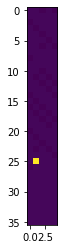

In [9]:
temp = outputs[2][:]
plt.imshow(temp)

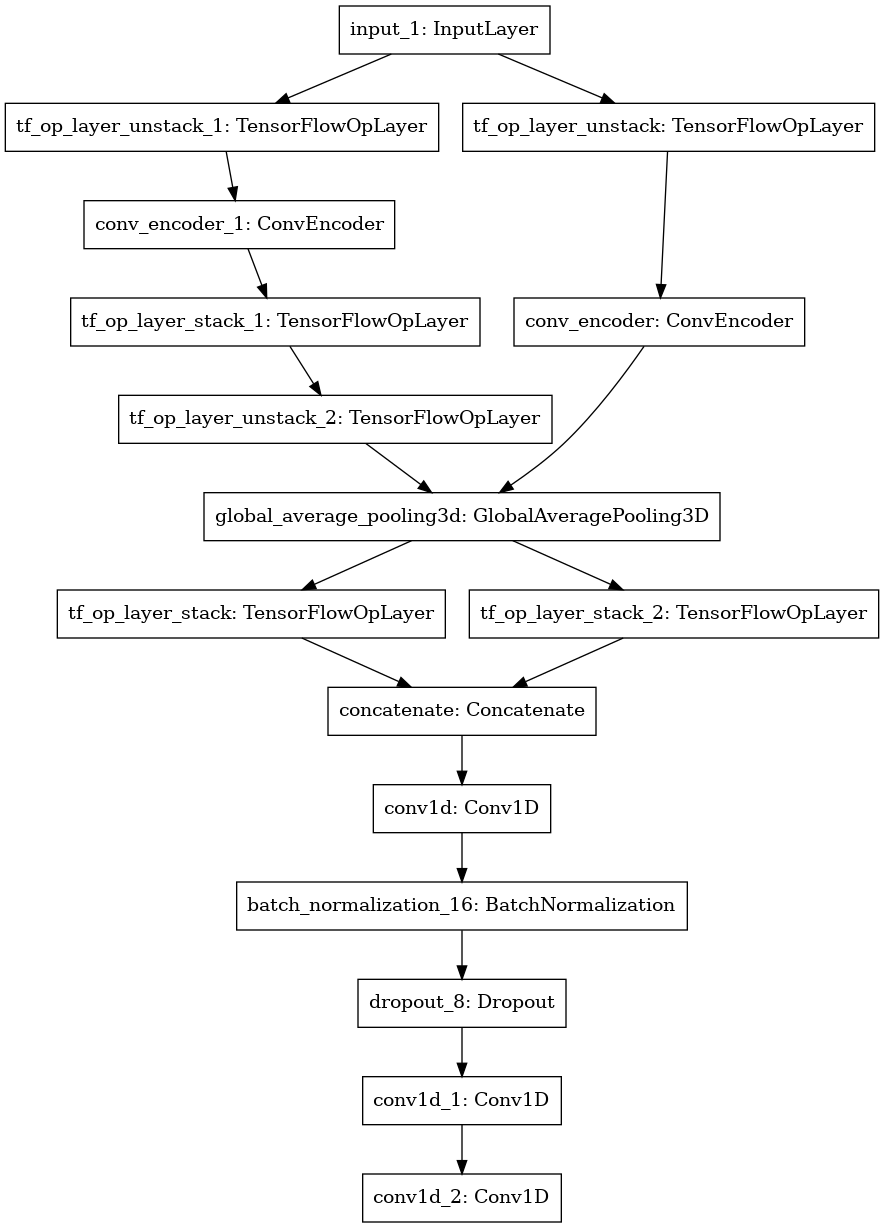

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [18]:
def meandiff_( y_true, y_pred, batchsize=4):

    """
    Average over the batches
    the sum of the absolute difference between two arrays
    y_true and y_pred are one-hot vectors with the following shape
    batchsize * timesteps * phase classes
    e.g.: 4 * 36 * 5
    First for gt and pred:
    - get the timesteps per phase with the highest probability
    - get the absolute difference between gt and pred
    (- later we can slice each patient by the max value in the corresponding gt indices)
    - sum the diff per entity
    - calc the mean over all examples

    Parameters
    ----------
    y_true :
    y_pred :

    Returns tf.float32 scalar
    -------

    """

    score = 0
    y_true = tf.cast(tf.convert_to_tensor(y_true), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)

    gt_idxs = tf.math.argmax(y_true, axis=1)
    gt_max = tf.cast(tf.reduce_max(gt_idxs, axis=1), tf.int32)
    padded_pred = []
    padded_gt = []

    msk = tf.stack([
        tf.pad(tf.ones((gt_max[i],5)), ((0,36-gt_max[i]),(0,0)))
        for i in range(batchsize)])
    #msk = tf.zeros_like(y_pred)
    #msk[:,:tf.reduce_max(gt_max), :] = 1

    temp_pred = y_pred * msk
    temp_gt = y_true * msk

    #y_pred = tf.unstack(y_pred, axis=0)
    #y_true = tf.unstack(y_true, axis=0)

    """def pad_to_size(p, max_id):
        to_pad = p.shape[0] - max_id
        print(p.shape[0])
        print(max_id)
        print(to_pad)
        return tf.pad(p, [[0,to_pad],[0,0]])

    padded_pred = list(map(lambda x : pad_to_size(x[0], x[1]), zip(y_pred, gt_max)))
    padded_gt = list(map(lambda x: pad_to_size(x[0], x[1]), zip(y_true, gt_max)))"""

    """for idx in tf.range(y_pred.shape[0]):
        max_idx = gt_max[idx]
        p = y_pred[idx][:max_idx, :]
        to_pad = y_pred.shape[1] - max_idx
        padded_pred.append(tf.pad(p, [[0,to_pad],[0,0]]))

        y = y_true[idx][:max_idx, :]
        padded_gt.append(tf.pad(y, [[0, to_pad], [0, 0]]))"""

    #temp_pred = tf.stack(padded_pred, axis=0)
    #temp_gt = tf.stack(padded_gt, axis=0)

    gt_idx = tf.math.argmax(temp_gt, axis=1)
    pred_idx = tf.math.argmax(temp_pred, axis=1)

    diffs = tf.stack([tf.stack(get_min_dist_for_list(gt_idx[i],pred_idx[i], batchsize)) for i in range(batchsize)])

    #diffs = tf.math.subtract(gt_idx, pred_idx)
    #print('substract: {}'.format(diffs.numpy()))
    #diffs = tf.abs(diffs)
    #print('abs: {}'.format(diffs.numpy()))
    diffs = tf.cast(tf.reduce_sum(diffs, axis=1),tf.float32)
    #print('sum: {}'.format(diffs.numpy()))
    diffs = tf.reduce_mean(diffs)

    return diffs


def get_min_dist_for_list(lst_a,lst_b, batchsize):
    length = tf.reduce_max(tf.stack([lst_a, lst_b]))
    #print(length)
    #length = max(max(lst_a), max(lst_b)) + 1
    return [get_min_distance(lst_a[i],lst_b[i],length) for i in range(batchsize)]

def get_min_distance(a, b, mod):
    #assert(mod>(tf.reduce_max(a,b))), 'a: {}, b: {}, mod:{}, '.format(a,b,mod)

    decr_counter = 0
    incr_counter = 0

    smaller = tf.reduce_min(tf.stack([a, b]))
    bigger = tf.reduce_max(tf.stack([a, b]))

    i1 = bigger
    while (i1 != smaller):
        decr_counter = decr_counter + 1
        i1 = i1 - 1

    i1 = bigger
    while (i1 != smaller):
        incr_counter = incr_counter + 1
        i1 = tf.math.mod((i1 + 1), mod)
        #i1 =  % mod

    return tf.reduce_min(tf.stack([decr_counter, incr_counter]))

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)